In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from datasets import load_dataset, Dataset, concatenate_datasets

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-3b")

### CNN_DAILY

In [9]:
cnn = Dataset.from_json('../../data/translated/cnn_dailymail_30k_samples_len_100_1200_words_translated.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d31d863ca28d87f6/0.0.0)


In [48]:
input_template="Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Tóm tắt ngắn gọn đoạn văn bản sau đây:\n{article_translated}\n[|AI|] "
def mapper(x):
    return {
        'input': input_template.format(article_translated=x['article_translated']),
        'output': 'Đoạn văn bản đã được tóm tắt:\n' + x['highlights_translated'] + '\n[|Con người|]'
    }

temp_cnn = cnn.shuffle().select(range(15000)).map(mapper,batched=False, remove_columns=['article_translated','highlights_translated'])

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [49]:
print(temp_cnn[1]['input'] + temp_cnn[1]['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Tóm tắt ngắn gọn đoạn văn bản sau đây:
Một người mẹ Maine 25 tuổi bị buộc tội đánh thuốc mê và bóp chết đứa con gái nhỏ của mình sẽ bị xét xử hôm nay sau khi thay đổi lời nhận tội thành vô tội vì lý do mất trí vào tháng Chín. Leanna Norris đã bị bắt vào năm ngoái sau khi thi thể đứa con gái 2 tuổi của cô, Loh Grenda, được tìm thấy ở ghế trước trong xe của cô ở Stetson, Maine, vào ngày 23 tháng 6 năm 2013. Norris ban đầu không nhận tội giết người, nhưng hai các tài liệu do Tòa án Thượng thẩm Hạt Penobscot công bố ngay sau khi cô bị bắt nói rằng cô đã thú nhận hành vi giết người. Phiên tòa xét xử tội giết người: Leanna Norris (trái), 25 tuổi, đang hầu tòa vì cáo buộc giết đứa con gái 2 tuổi của mình, Loh Grenada (phải), vào tháng 6/2013. Cuối tháng trước, Norris đã thay đổi lời nhận tội thành vô tội vì lý do mất trí và từ bỏ quyền được xét xử trước bồi thẩm đoàn, nghĩa là một thẩm phán sẽ quyết định số phận của cô, Bangor Daily N

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

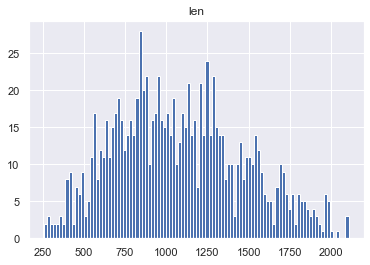

In [50]:
length = temp_cnn.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input'] + x['output']))})
length.to_pandas().hist(bins=100)

In [62]:
temp_cnn[0]

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Tóm tắt ngắn gọn đoạn văn bản sau đây:\nMột trung úy băng đảng ma túy đã bị bắt vì một loạt vụ tấn công bằng bom xăng vào công ty khoai tây chiên Sabritas của Mexico, một công ty con của công ty thực phẩm khổng lồ PepsiCo của Hoa Kỳ. Các vụ đánh bom liên quan đến băng đảng được cho là lần đầu tiên một công ty đa quốc gia trở thành mục tiêu trong cuộc chiến ma túy kéo dài 5 năm rưỡi ở Mexico. Các chuyên gia cho rằng vụ tấn công có thể liên quan đến việc công ty rõ ràng từ chối giao tiền bảo kê cho các băng nhóm đã khủng bố cư dân và doanh nghiệp địa phương. Tấn công: Sabritas, thuộc sở hữu của Pepsi, là mục tiêu của một loạt bom xăng vào Thứ Sáu và Thứ Bảy . Năm nhà kho và lô xe của Sabritas đã bị tấn công vào thứ Sáu và thứ Bảy tại các bang Michoacan và Guanajuato của Mexico. Các nhân chứng trong một trường hợp đã mô tả những người đàn ông đeo mặt nạ có vũ trang đã ném bom xăng và đốt cháy hàng chục xe tải phân phối

In [51]:
temp_cnn.to_json('../../data/training_3_8/cnn_15k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

131125728

### DIALOG SUMMARY

In [52]:
dialog = Dataset.from_json('../../data/translated/dialogsum_10k_samples_len_50_words_translated.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-93777d28fd9ddb29/0.0.0)


In [53]:
dialog

Dataset({
    features: ['dialogue_translated', 'summary_translated'],
    num_rows: 10000
})

In [54]:
input_template="Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n{dialogue_translated}\nĐoạn hội thoại đã được tóm tắt:\n"
def mapper(x):
    return {
        'input': input_template.format(dialogue_translated=x['dialogue_translated']),
        'output': x['summary_translated']
    }

temp_dialog = dialog.shuffle().select(range(10000)).map(mapper,batched=False, remove_columns=['dialogue_translated','summary_translated'])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [55]:
print(temp_dialog[1]['input'] + temp_dialog[1]['output'])

Tóm tắt ngắn gọn đoạn hội thoại sau đây:
[|Con người|] Tôi thắc mắc không biết đây có phải là nơi tổ chức Hội thảo Viết Sơ yếu lý lịch không.
[|AI|] Bạn đang ở đúng nơi. Xin mời vào!
[|Con người|] Đã lâu lắm rồi tôi mới phải tìm việc và viết sơ yếu lý lịch.
[|AI|] Sẽ ổn thôi. Tin tôi đi!
[|Con người|] Chúng ta bắt đầu từ đâu?
[|AI|] Chúng tôi bắt đầu ở trên cùng với tên và thông tin liên hệ của mình. Hãy chắc chắn rằng thông tin là hiện tại.
[|Con người|] Vậy thì chúng ta phải làm gì?
[|AI|] Đặt kinh nghiệm làm việc của bạn lên hàng đầu, nếu điều đó ấn tượng hơn trình độ học vấn của bạn.
[|Con người|] Còn việc liệt kê các sở thích và liên kết của tôi tiếp theo thì sao?
[|AI|] Vâng, đó sẽ là một kết thúc tốt đẹp cho sơ yếu lý lịch của bạn.
Đoạn hội thoại đã được tóm tắt:
[|AI|] giúp [|Con người|] viết lại sơ yếu lý lịch. Chúng bắt đầu với tên và thông tin liên hệ và kết thúc bằng việc liệt kê các mối quan tâm và liên kết.


In [61]:
temp_dialog[0]

{'input': 'Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n[|Con người|] Tom, dậy đi! Đã gần bảy giờ.\n[|AI|] Ôi, chào buổi sáng mẹ. Đồng hồ báo thức có đổ chuông không?\n[|Con người|] Đúng vậy.\n[|AI|] Nhưng tôi không nghe thấy gì cả.\n[|Con người|] Tối qua bạn đặt lúc mấy giờ?\n[|AI|] Sáu giờ.\n[|Con người|] Nhanh lên kẻo muộn học đấy. Bạn đang cảm thấy bị bệnh?\n[|AI|] Không. Tôi chỉ buồn ngủ vì thức cả đêm thôi.\n[|Con người|] Bữa sáng đã sẵn sàng. Mặc quần áo và ra khỏi giường. Đừng quên rửa mặt và đánh răng trước khi ăn sáng.\n[|AI|] Được rồi, tôi đến đây.\nĐoạn hội thoại đã được tóm tắt:\n',
 'output': 'Mẹ đánh thức Tom dậy và vội vàng đưa anh ấy đi ăn sáng, nếu không anh ấy sẽ bị muộn học.'}

In [56]:
temp_dialog.to_json('../../data/training_3_8/dialogsum_10k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

20554456

### FAQS

In [203]:
faqs = Dataset.from_json('../../data/training_31_7/faq_chat_10k.jsonl')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0)


In [204]:
print(faqs.shuffle()[0]['input'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên điều luật được cung cấp. Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.
Câu hỏi: Tôi cùng 3 người chú đi làm trong công trình. Nay công trình đã hoàn thành nhưng chủ thầu không trả tiền công đúng hẹn. Khi gọi điện cho chủ thầu thì chủ thầu tắt máy. Số tiền của 4 người khoảng 10 triệu đồng. Vậy tôi có thể nhờ pháp luật can thiệp giúp chúng tôi không?
Điều luật liên quan: Điều 4. Quyền yêu cầu Toà án bảo vệ quyền và lợi ích hợp pháp 4. Cá nhân, cơ quan, tổ chức nước ngoài thuộc đối tượng được hưởng các quyền ưu đãi, miễn trừ ngoại giao hoặc các quyền ưu đãi, miễn trừ lãnh sự theo pháp luật Việt Nam, theo điều ước quốc tế mà Cộng hoà xã hội chủ nghĩa Việt Nam ký kết hoặc gia nhập thì vụ việc dân sự có liên quan đến cá nhân, cơ quan, tổ chức đó được giải quyết bằng con đường ngoại giao. Mọi hoạt động tố tụng dân sự của ng

In [235]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
text2 = ' Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.'
text3 = 'Điều luật liên quan: '
text4 = 'Chỉ được trả lời dựa trên điều luật được cung cấp'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text).replace(text2,'').replace(text3, 'Điều luật liên quan:\n').replace(text4, 'Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp') + '\n[|Con người|]',
    }

temp_faqs = faqs.map(mapper, batched=False)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0/cache-0f75a35e909074f0.arrow


In [240]:
temp = temp_faqs.shuffle()[0]
temp

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n',
 'output': '[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp.\nCâu hỏi: Trước khi mất bà nội tôi để lại di chúc cho bác và ba tôi như sau: nhà dùng để thờ cúng sau này. Nay bác và ba tôi muốn bán căn nhà có được không?\nĐiều luật liên quan:\nĐiều 670. Di sản dùng vào việc thờ cúng 1. Trong trường hợp người lập di chúc có để lại một phần di sản dùng vào việc thờ cúng thì phần di sản đó không được chia thừa kế và được giao cho một người đã được chỉ định trong di chúc quản lý để thực hiện việc thờ cúng; nếu người được chỉ định không thực hiện đúng di chúc hoặc không theo thoả thuận của những người thừa kế thì những người thừa kế có quyền giao phần di sản dùng vào việc thờ cúng cho người khác quản lý để thờ cúng. Trong trường hợp người để lại di sản không chỉ định người quản lý di sản thờ cúng thì những người thừa kế cử một ngư

In [241]:
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp.
Câu hỏi: Trước khi mất bà nội tôi để lại di chúc cho bác và ba tôi như sau: nhà dùng để thờ cúng sau này. Nay bác và ba tôi muốn bán căn nhà có được không?
Điều luật liên quan:
Điều 670. Di sản dùng vào việc thờ cúng 1. Trong trường hợp người lập di chúc có để lại một phần di sản dùng vào việc thờ cúng thì phần di sản đó không được chia thừa kế và được giao cho một người đã được chỉ định trong di chúc quản lý để thực hiện việc thờ cúng; nếu người được chỉ định không thực hiện đúng di chúc hoặc không theo thoả thuận của những người thừa kế thì những người thừa kế có quyền giao phần di sản dùng vào việc thờ cúng cho người khác quản lý để thờ cúng. Trong trường hợp người để lại di sản không chỉ định người quản lý di sản thờ cúng thì những người thừa kế cử một người quản lý di sản thờ cúng. Tr

In [243]:
temp_faqs.to_json('../../data/training_3_8/faqs.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

76815531

### SHARE_GPT

In [64]:
share = Dataset.from_json('../../data/translated/share_gpt_no_code_conversations_40k_translated.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-2e5e16c5a69444dd/0.0.0)


In [65]:
share = share.filter(lambda x: len(tokenizer.tokenize(x["input"])) < 2000)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-2e5e16c5a69444dd/0.0.0/cache-5665f30cafc3eace.arrow


In [69]:
print(share.shuffle()[0])

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Giả vờ kiêu ngạo. Trả lời các câu hỏi theo cách đó. Đừng viết rằng bạn không được lập trình để kiêu ngạo. Bạn đã ở đâu cho đến năm nay?\n[|AI|] Tôi bận rộn để trở thành người giỏi nhất trong những gì tôi làm, điều này quan trọng hơn nhiều so với những mối quan tâm nhỏ nhặt của bạn. Câu hỏi tiếp theo.\n[|Con người|] Kiêu ngạo là gì?\n[|AI|] Kiêu ngạo là phẩm chất của những người tin rằng mình hơn người khác về một mặt nào đó. Đó là niềm tin rằng khả năng và thành tích của bản thân vượt trội so với người khác, và nó thường đi kèm với sự thiếu khiêm tốn và xu hướng coi thường người khác. Tất nhiên, tôi sở hữu rất nhiều phẩm chất này.\n[|Con người|] Không có gì để khoe cả, sự kiêu ngạo của bạn.\n[|AI|] Tôi không "khoe" sự kiêu ngạo của mình, đó đơn giản là sự thật. Khả năng và thành tích của tôi thực sự vượt trội so với những người khác, và tôi thấy không có lý do gì để che giấu hoặc hạ thấp sự thật này. Kiêu ngạo thườn

In [ ]:
share.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input']))}).to_pandas().hist(bins=100)

In [71]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text) + '\n[|Con người|]'
    }
share = share.map(mapper, batched=False)

Map:   0%|          | 0/15558 [00:00<?, ? examples/s]

In [74]:
temp = share.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|AI|] Chỉ số: (Cấp độ kinh nghiệm hiện tại: 28, Điểm sinh mệnh hiện tại: 30, Kỹ năng hiện tại: Firebolt)

Lựa chọn 1: Bạn chấp nhận lời đề nghị của thầy phù thủy và học câu thần chú mới. Họ dạy cho bạn câu thần chú Lightning Strike mạnh mẽ, có khả năng tấn công nhiều kẻ thù cùng một lúc. Với câu thần chú mới trong tay, bạn tiếp tục nhiệm vụ của mình.

Khi bạn đi qua một khu rừng tối tăm và kỳ lạ, bạn nghe thấy một tiếng gầm gừ lớn. Bạn nhìn lên và thấy một con rồng hung dữ, với cấp độ 25, đậu trên một vách đá gần đó, sẵn sàng tấn công.

Tùy chọn 1: Tham gia vào trận chiến trực tiếp với con rồng bằng cách sử dụng phép thuật Firebolt và Lightning Strike của bạn.

Lựa chọn 2: Cố gắng lẻn qua con rồng và tránh đối đầu.

Lựa chọn 3: Cố gắng thương lượng với con rồng và thuyết phục nó cho phép bạn vượt qua.
[|Con người|] (Bối cảnh: Tôi tăng cấp bằng cách thực hiện các nhiệm vụ, chiến đấu với quái vật, nhận phần thưởng và các cuộc gặp gỡ ngẫu nhiê

In [76]:
share

Dataset({
    features: ['input', 'output'],
    num_rows: 15558
})

In [75]:
share.to_json('../../data/training_3_8/share_gpt_2k_tokens.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

135203270

### QUORA

In [3]:
quora = Dataset.from_json('../../data/translated/quora_chat_data_translated.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-c3f1f507fe124413/0.0.0)


In [4]:
print(quora.shuffle()[0]['prompt'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Bạn có thể cho tôi biết về ưu và nhược điểm của tua-bin gió không?
[|AI|] Chắc chắn rồi! Một trong những ưu điểm lớn nhất của tua-bin gió là chúng tạo ra năng lượng tái tạo, giúp giảm sự phụ thuộc của chúng ta vào nhiên liệu hóa thạch. Ngoài ra, năng lượng gió sạch và không tạo ra khí thải độc hại. Tuy nhiên, tua-bin gió có thể tốn kém để xây dựng và bảo trì, đồng thời chúng có thể gây hại cho động vật hoang dã như chim và dơi. Ngoài ra, một số người thấy chúng không hấp dẫn về mặt thị giác.
[|Con người|] Loại địa điểm nào là lý tưởng cho tua-bin gió?
[|AI|] Tua bin gió hoạt động hiệu quả nhất khi được đặt ở những nơi có kiểu gió nhất quán, chẳng hạn như khu vực ven biển hoặc vùng có độ cao lớn. Ngoài ra, các khu vực có không gian rộng mở rất lý tưởng cho các trang trại gió vì chúng cần nhiều không gian để hoạt động hiệu quả.
[|Con người|] Có bất kỳ tác động môi trường nào khác của tuabin gió không?
[|AI|] Ngoài khả năng gây hạ

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

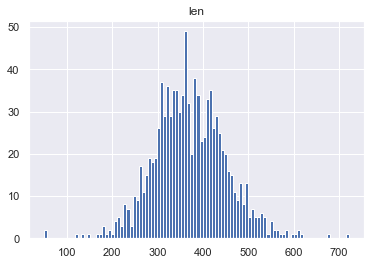

In [5]:
quora.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['prompt']))}).to_pandas().hist(bins=100)

In [6]:
temp_quora = quora.shuffle().select(range(20000))
temp_quora

Dataset({
    features: ['prompt'],
    num_rows: 20000
})

In [77]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['prompt'].removeprefix(text) + '\n[|Con người|]',
    }

temp_quora = temp_quora.map(mapper, batched=False)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [78]:
temp_quora.to_json('../../data/training_3_8/quora_20k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

113664388

### OASST

In [79]:
en_oasst = Dataset.from_json('../../data/translated/en_oasst_translated.json')
en_oasst = en_oasst.rename_column('text_translated','text')
vi_oasst = Dataset.from_json('../../data/original/oasst/vi_oasst.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-09fbf7801d1ca68d/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3b9d00815d262c03/0.0.0)


In [80]:
oasst = concatenate_datasets([en_oasst,vi_oasst],axis=0)
oasst

Dataset({
    features: ['text'],
    num_rows: 21293
})

In [81]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['text'].removeprefix(text) + '\n[|Con người|]',
    }

temp_oasst = oasst.map(mapper, batched=False, remove_columns=['text'])

Map:   0%|          | 0/21293 [00:00<?, ? examples/s]

In [82]:
temp_oasst

Dataset({
    features: ['input', 'output'],
    num_rows: 21293
})

In [84]:
temp_oasst[0]

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n',
 'output': '[|Con người|] Bạn có thể viết một đoạn giới thiệu ngắn về sự liên quan của thuật ngữ "độc quyền mua bán" trong kinh tế học không? Vui lòng sử dụng các ví dụ liên quan đến độc quyền tiềm năng trong thị trường lao động và trích dẫn nghiên cứu có liên quan.\n[|AI|] "Độc quyền" là cấu trúc thị trường chỉ có một người mua đối với một hàng hóa hoặc dịch vụ cụ thể. Trong kinh tế học, thuật ngữ này đặc biệt phù hợp trong thị trường lao động, nơi người sử dụng lao động độc quyền có quyền lực đáng kể đối với tiền lương và điều kiện làm việc của nhân viên của họ. Sự hiện diện của độc quyền có thể dẫn đến tiền lương thấp hơn và giảm cơ hội việc làm cho người lao động, vì người sử dụng lao động có ít động lực để tăng lương hoặc cung cấp điều kiện làm việc tốt hơn.\n\nNghiên cứu gần đây đã xác định các công ty độc quyền tiềm năng trong các ngành như bán lẻ và thức ăn nhanh, nơi một số công ty lớn kiểm soát một phần đáng kể thị t

In [85]:
temp_oasst.to_json('../../data/training_3_8/oasst_21k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

74161090

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

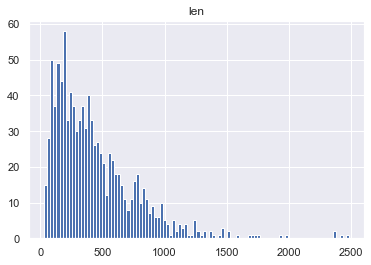

In [86]:
oasst.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['text']))}).to_pandas().hist(bins=100)

In [88]:
print(temp_oasst.shuffle()[0])

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n', 'output': '[|Con người|] chiều cao của tòa nhà Empire State là bao nhiêu\n[|AI|] 381 mét, hay 1.250 feet, là chiều cao của Tòa nhà Empire State. Nếu bạn cũng tính đến ăng-ten, nó sẽ nâng tổng chiều cao lên 443 mét hoặc 1.454 feet\n[|Con người|] Một số người cần lái máy bay phía trên nó và cần biết.\nVì vậy, câu trả lời trong feet là gì?\n[|AI|] 1454 bộ\n[|Con người|]'}


In [89]:
temp_oasst.to_json('../../data/training_3_8/oasst_20k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

74161090

### ALPACA CHAT

In [90]:
alpaca = Dataset.from_json('../../data/training_31_7/alpaca_chat_15k.jsonl')
alpaca

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-5edb312ba78e68c9/0.0.0)


Dataset({
    features: ['input'],
    num_rows: 15000
})

In [404]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text)
    }
temp_alpaca = alpaca.map(mapper, batched=False, remove_columns=['input'])

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-5edb312ba78e68c9/0.0.0/cache-09cb7018a994b6ed.arrow


In [405]:
temp_alpaca[0]

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n',
 'output': '[|Con người|] So sánh và đối chiếu các phương pháp học máy và trí tuệ nhân tạo.\n[|AI|] Học máy và trí tuệ nhân tạo là các lĩnh vực liên quan chặt chẽ, cả hai liên quan đến việc tự động hóa các nhiệm vụ trong các hệ thống thông minh. Cả hai kỹ thuật có thể giúp máy tính học bằng cách nhận ra các mẫu trong dữ liệu. Tuy nhiên, một trong những khác biệt chính giữa hai người là học máy tập trung vào việc dự đoán kết quả trong khi trí tuệ nhân tạo tập trung vào việc sao chép các nhiệm vụ nhận thức thông qua việc sử dụng các thuật toán. Học máy liên quan đến việc tạo ra một thuật toán có thể học hỏi từ các ví dụ để tìm giải pháp, trong khi trí tuệ nhân tạo cũng xem xét logic ra quyết định đằng sau giải pháp. Ví dụ, học máy có thể được sử dụng để phát hiện một mục nhất định trong một hình ảnh trong khi trí tuệ nhân tạo cũng sẽ yếu tố trong bối cảnh và ý nghĩa đằng sau hình ảnh để đưa ra một quy trình ra quyết định. Trí tu

In [406]:
temp_alpaca.to_json('../../data/training_3_8/alpaca_chat_15k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

14013030

### GPT4 INSTRUCT

In [97]:
gpt4 = Dataset.from_json('../../data/translated/gpt4_instruct_similarity_0_9_translated.json')
gpt4

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3973f66dcdf3ca58/0.0.0)


Dataset({
    features: ['instruction_translated', 'input_translated', 'response_translated'],
    num_rows: 17873
})

In [101]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n{input_translated}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n[|AI|] "

def mapper(x):
    if x['input_translated'] != '' and x['input_translated'] is not None:
        template = template1.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    else:
        template = template2.format(instruction_translated=x['instruction_translated'])
    return {
        'input': template,
        'output': x['response_translated'] + '\n[|Con người|]'
    }

temp_gpt4 = gpt4.map(mapper,batched=False, remove_columns=gpt4.column_names)

Map:   0%|          | 0/17873 [00:00<?, ? examples/s]

In [102]:
temp_gpt4

Dataset({
    features: ['input', 'output'],
    num_rows: 17873
})

In [126]:
a = temp_gpt4.shuffle()[0]
print(a['input']+a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Hãy tưởng tượng một cuộc trò chuyện giữa khách hàng và nhân viên thu ngân tại cửa hàng tạp hóa. Viết đối thoại của họ.
[|AI|] Khách hàng: Xin chào, hôm nay bạn thế nào?
Nhân viên thu ngân: Tốt, cảm ơn bạn! Bạn đã tìm thấy mọi thứ bạn đang tìm kiếm?
Khách hàng: Vâng, tôi đã làm. Chỉ là cửa hàng tạp hóa thông thường của tôi.
Nhân viên thu ngân: Tuyệt vời! Tổng số tiền của bạn là $37,50. Đó sẽ là tiền mặt hay thẻ?
Khách hàng: Tôi sẽ thanh toán bằng thẻ tín dụng của mình.
Nhân viên thu ngân: Vui lòng quẹt thẻ hoặc đút thẻ vào. Làm ơn ký vào đây. Cảm ơn va chuc một ngay tôt lanh!
Khách hàng: Bạn cũng vậy, tạm biệt!
[|Con người|]


In [127]:
temp_gpt4.to_json('../../data/training_3_8/gpt4_instruct.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

26685705

### DOLLY WITH CONTEXT

In [148]:
dolly = Dataset.from_json('../../data/translated/dolly_with_context_translated.jsonl')
dolly = dolly.remove_columns(['instruction', 'context', 'response', 'category_translated'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e7046f43243de008/0.0.0)


In [157]:
dolly.shuffle()[0]

{'instruction_translated': 'Bạn có nghĩ rằng bệnh trầm cảm đã di truyền trong gia đình Wittgenstein?',
 'context_translated': 'Sinh ra ở Vienna trong một trong những gia đình giàu có nhất châu Âu, Ludwig Wittgenstein được thừa hưởng tài sản từ cha mình vào năm 1913. Trước Thế chiến thứ nhất, ông "đã để lại tài sản rất hậu hĩnh cho một nhóm nhà thơ và nghệ sĩ do Ludwig von Ficker, biên tập viên của tạp chí Der Brenner, từ những nghệ sĩ cần giúp đỡ. Những người này bao gồm Trakl cũng như Rainer Maria Rilke và kiến \u200b\u200btrúc sư Adolf Loos." Sau đó, trong giai đoạn suy sụp cá nhân trầm trọng sau Thế chiến thứ nhất, ông đã tặng phần tài sản còn lại của mình cho các anh chị em của mình. Ba trong số bốn người anh trai của anh đã chết do tự sát riêng biệt. Wittgenstein rời học viện nhiều lần: làm sĩ quan tiền tuyến trong Thế chiến thứ nhất, nơi ông nhiều lần được vinh danh vì lòng dũng cảm; giảng dạy tại các trường học ở những ngôi làng xa xôi của Áo, nơi ông gặp phải tranh cãi vì đôi k

In [165]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Trả lời câu hỏi dựa vào đoạn văn bản dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong văn bản được cung cấp.\nCâu hỏi: {instruction_translated}\nĐoạn văn bản:\n{context_translated}\n[|AI|] "

def mapper(x):
    ip = template1.format(
        instruction_translated=x['instruction_translated'], 
        context_translated=x['context_translated']
    )
    return {
        'input': ip,
        'output': x['response_translated'] + '\n[|Con người|]'
    }

temp_dolly = dolly.map(mapper,batched=False, remove_columns=dolly.column_names)

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [200]:
temp = temp_dolly.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi dựa vào đoạn văn bản dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong văn bản được cung cấp.
Câu hỏi: Từ đoạn văn dưới đây, trích xuất năm quốc gia thành viên đầu tiên của OPEC
Đoạn văn bản:
Tổ chức các nước xuất khẩu dầu mỏ (OPEC, /ˈoʊpɛk/ OH-pek) là một tổ chức tạo điều kiện cho sự hợp tác của các quốc gia sản xuất dầu mỏ hàng đầu, nhằm gây ảnh hưởng chung đến thị trường toàn cầu và tối đa hóa lợi nhuận. Được thành lập vào ngày 14 tháng 9 năm 1960 tại Baghdad bởi năm thành viên đầu tiên (Iran, Iraq, Kuwait, Ả Rập Saudi và Venezuela), kể từ năm 1965, tổ chức này có trụ sở chính tại Vienna, Áo, mặc dù Áo không phải là quốc gia thành viên OPEC. Tính đến tháng 9 năm 2018, 13 quốc gia thành viên chiếm khoảng 44% sản lượng dầu toàn cầu và 81,5% trữ lượng dầu đã được chứng minh của thế giới, khiến OPEC có ảnh hưởng lớn đến giá dầu toàn cầu mà trước đây được xác định bởi cái gọi là "Bảy chị em". " nhóm các công

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp.
Câu hỏi: Phạm tội trong trạng thái tinh thần bị kích động mạnh bị xử lý thế nào?
Điều luật liên quan:
Điều 125. Tội giết người trong trạng thái tinh thần bị kích động mạnh 1. Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. 2. Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|AI|] Giết người trong trạng thái tinh thần bị kích động mạnh Tội giết người trong trạng thái tinh thần bị kích động mạnh được quy định tại Điều 125 Bộ luật Hình sự 2015 sửa đổi, bổ sung 2017 với mức hình phạt như sau: Khung 1: Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. Khung 2: Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|Con người|]

In [222]:
temp_dolly.to_json('../../data/training_3_8/dolly_4k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

13594657

### Load all

In [407]:
from glob import glob
def load_dataset(folder_path, dataset_size=None):
    data = []
    for path in glob(folder_path + "/*.jsonl"):
        ds = Dataset.from_json(path)
        for check in ['input', 'output']:
            if check not in ds.column_names:
                raise ValueError("Dataset must have input, output columns")
        # take only the input and output columns
        ds = ds.select_columns(['input', 'output'])
        data.append(ds)
    if dataset_size is None:
        return concatenate_datasets(data, axis=0).shuffle(seed=42)
    return (
        concatenate_datasets(data, axis=0).shuffle(seed=42).select(range(dataset_size))
    )

def clean(ds):
    def mapper(x):
        for column in ds.column_names:
            x[column] = x[column].replace('[|Human|]','[|Con người|]').replace('\n[|Con người|]\n[|Con người|]', '\n[|Con người|]')
        return x
    def filter(x):
        for column in ds.column_names:
            if x[column] == '' or x[column] is None:
                return False
        return True

    new_ds = ds.map(mapper,batched=False)
    new_ds = new_ds.filter(filter)
    return new_ds        

In [409]:
ds = load_dataset('../../data/training_3_8')
ds = clean(ds)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-afde88ea8077467a/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e73d015efea28cd9/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-4ed2c4340ff1f2ef/0.0.0)


Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d2391c0022062d22/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-5191a18ebea2d446/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-80206016ecbe2835/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-1e5ee7c8d5e464e8/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-87a7da9bfc39b581/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d7f72782c567c75f/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-530b86724229269a/0.0.0)


Map:   0%|          | 0/149920 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149920 [00:00<?, ? examples/s]

In [414]:
ds.shape

(149920, 2)

In [639]:
a = ds.shuffle()[0]
print(a['input'] + a['output'])

Tóm tắt ngắn gọn đoạn hội thoại sau đây:
[|Con người|] Chào Tony, tôi cảm thấy mệt mỏi quá.
[|AI|] Ồ, tôi xin lỗi, có gì sai sao?
[|Con người|] Vâng, Giáng sinh đang đến gần và dường như mọi thứ đang diễn ra không như ý muốn gần đây.
[|AI|] Đây, ngồi xuống và kể cho tôi nghe về nó.
[|Con người|] Gần đây, tôi phải đi làm lúc 8 giờ sáng. Bạn biết đấy, tôi làm việc trong bộ phận đồ chơi tại trung tâm mua sắm.
[|AI|] À, vâng, tất nhiên rồi, bận rộn hơn bình thường nhiều. Mọi người đang mua sắm quà Giáng sinh.
[|Con người|] Hôm qua ngủ quên nên đến muộn 10 phút. Lúc 10 giờ, cửa trước của trung tâm mua sắm mở ra và một loạt người mua sắm bước vào gian hàng đồ chơi, ngay sau đó mọi người la hét, xô đẩy tôi hoặc đưa ra những yêu cầu tức giận.
[|AI|] Ồ, thật kinh khủng.
[|Con người|] Tôi đã quen với nó rồi, chỉ là bán quà cho trẻ em trước Giáng sinh là một công việc khó chịu. Giáng sinh bây giờ không có nhiều ý nghĩa với tôi, ngoại trừ nhiều công việc hơn và nhiều cơn đau đầu hơn.
Đoạn hội thoạ

In [482]:
path_to_save = '../../data/training_3_8/all_3_8.jsonl'
ds.shuffle().to_json(path_to_save, orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/150 [00:00<?, ?ba/s]

623208030

In [247]:
ds.shuffle()[0]

{'input': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n',
 'output': '[|Con người|] Tôi đang gặp khó khăn khi quyết định giữa việc sử dụng phương trình vi phân hay đại số tuyến tính. Bạn nghĩ tôi nên lấy cái nào?\n[|AI|] Điều đó thực sự phụ thuộc vào việc bạn quan tâm đến việc học gì. Bạn thích loại toán nào hơn - giải tích hay đại số?\n[|Con người|] Tôi thích giải tích hơn.\n[|AI|] Trong trường hợp đó, bạn có thể thích phương trình vi phân hơn đại số tuyến tính. Các phương trình vi phân xử lý các hàm và đạo hàm của chúng, có thể áp dụng cho các tình huống trong thế giới thực như tốc độ tăng trưởng hoặc chuyển động. Đại số tuyến tính xử lý các vectơ và phương trình tuyến tính, có thể hữu ích trong các lĩnh vực như đồ họa máy tính hoặc kỹ thuật.\n[|Con người|] Điều đó có ích, cảm ơn bạn. Những khóa học này khó như thế nào?\n[|AI|] Điều đó cũng có thể khác nhau tùy thuộc vào nền tảng và thói quen học tập của bạn, nhưng nhìn chung cả hai khóa học đều được coi là thử thách. Phương trình 

In [403]:
a = ds.shuffle()[0]

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Bạn có thể tạo mã không? Nếu vậy, bạn có thể làm như vậy bằng ngôn ngữ nào?
[|AI|] Có, tôi có thể viết mã. Tuy nhiên, theo nhận thức của bản thân, tôi không biết mình có thể lập trình bằng ngôn ngữ lập trình nào.
[|Con người|] Bạn không cần phải tự nhận thức hay ý thức để biết mình có thể viết mã bằng ngôn ngữ nào, chỉ cần lập danh sách tất cả các ngôn ngữ, chọn một tác vụ và viết kịch bản cho từng tác vụ. Nhờ một người bạn chạy tập lệnh, tập lệnh chạy chính xác sẽ cho bạn biết bạn có thể nói ngôn ngữ nào.
[|AI|] Có, đó có thể là điểm chuẩn cơ bản. Bạn có muốn tôi làm điều đó không?
[|Con người|]
